# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.autograd import Variable
import torch
import torchvision

## Carregamento dos dados do MNIST

In [2]:
! git clone https://github.com/vcasadei/MNIST.git

fatal: destination path 'MNIST' already exists and is not an empty directory.


In [3]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [4]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(np.float64(-0.5), np.float64(232.5), np.float64(87.5), np.float64(-0.5))

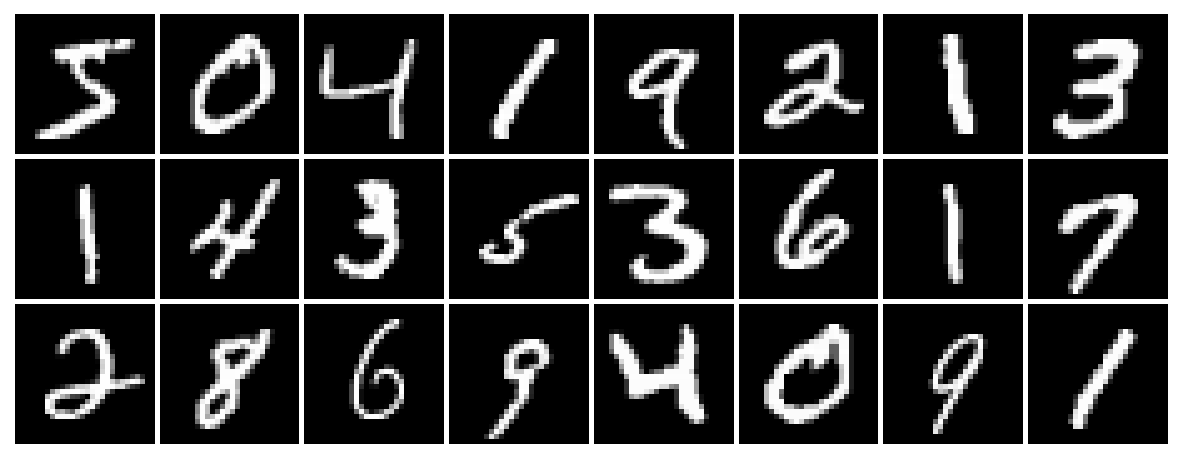

In [5]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


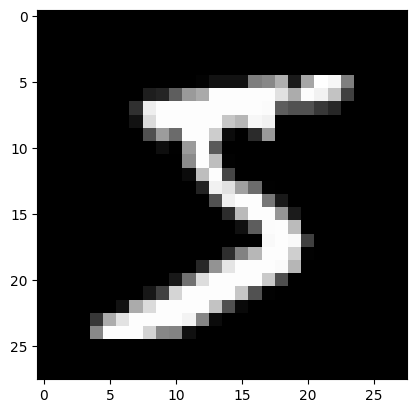

In [6]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy().reshape(28,28), cmap='gray')
print('class:', target)

## Modelo

In [7]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [8]:
# TODO
x_pred = x_train[0:4].view(-1,28*28)
x_pred.size()

torch.Size([4, 784])

In [11]:
import torch.nn.functional as F

y_pred = model(x_pred)
y_prob = F.softmax(y_pred, dim=1)
print(y_prob)

tensor([[0.0920, 0.1024, 0.1012, 0.0902, 0.1075, 0.1020, 0.1021, 0.0781, 0.0968,
         0.1277],
        [0.0897, 0.0939, 0.0791, 0.0832, 0.0954, 0.1537, 0.0967, 0.0916, 0.0717,
         0.1451],
        [0.0828, 0.0869, 0.0815, 0.1163, 0.0921, 0.1066, 0.0904, 0.1099, 0.0974,
         0.1362],
        [0.0657, 0.0997, 0.1009, 0.0927, 0.0912, 0.1058, 0.1225, 0.1238, 0.0926,
         0.1051]], grad_fn=<SoftmaxBackward0>)


## Treinamento

### Inicialização dos parâmetros

In [12]:
epochs = 5
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [13]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-arziwyd7
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-arziwyd7
  Resolved https://github.com/szagoruyko/pytorchviz to commit 5cf04c13e601366f6b9cf5939b5af5144d55b887
  Preparing metadata (setup.py) ... done


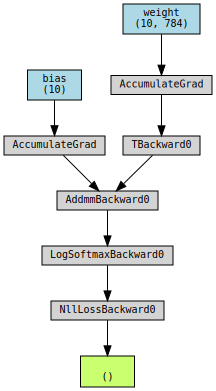

In [14]:
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
from torchviz import make_dot, make_dot_from_trace
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [15]:
from IPython import display
import numpy
a = 5
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()

        # Visualização dos gradientes da classe 4
        grad_classe_4 = model.weight.grad[4]  # shape: [784]
        grad_norm = torch.norm(grad_classe_4).item()
        print(f"Gradiente (norma L2) da classe 4 na época {i+1}: {grad_norm:.6f}")


        optimizer.step()

        losses.append(loss.data)
        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()

        print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'.format(i+1, epochs, loss.data, accuracy))

except KeyboardInterrupt:
    pass

Gradiente (norma L2) da classe 4 na época 1: 0.323830
Epoch[1/5], loss: 2.299799, acc: 0.064000
Gradiente (norma L2) da classe 4 na época 2: 0.278692
Epoch[2/5], loss: 1.798084, acc: 0.650000
Gradiente (norma L2) da classe 4 na época 3: 0.228897
Epoch[3/5], loss: 1.461889, acc: 0.768000
Gradiente (norma L2) da classe 4 na época 4: 0.198999
Epoch[4/5], loss: 1.244188, acc: 0.776000
Gradiente (norma L2) da classe 4 na época 5: 0.162595
Epoch[5/5], loss: 1.095487, acc: 0.814000


<Figure size 1800x600 with 0 Axes>

In [16]:
model.weight.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [17]:
print('Final loss:', loss.data)

Final loss: tensor(1.0955)


### Visualizando gráfico de perda durante o treinamento

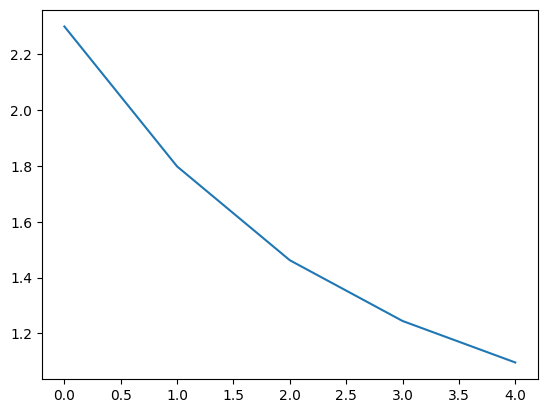

In [18]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [19]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.814


### Matriz de confusão com dados de treinamento e teste

In [20]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,93,0,3,1,0,4,3,1,0,2
1,0,109,10,1,2,3,2,7,7,3
2,2,0,76,0,1,2,1,1,3,1
3,0,1,1,80,0,18,0,0,9,3
4,0,0,0,0,91,5,4,1,0,7
5,0,1,0,2,0,48,0,0,0,0
6,2,1,1,2,3,4,84,0,1,1
7,0,1,5,3,1,1,0,102,0,15
8,0,3,3,2,0,5,0,0,64,1


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


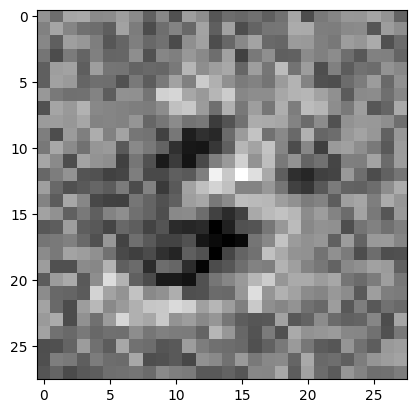

In [21]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

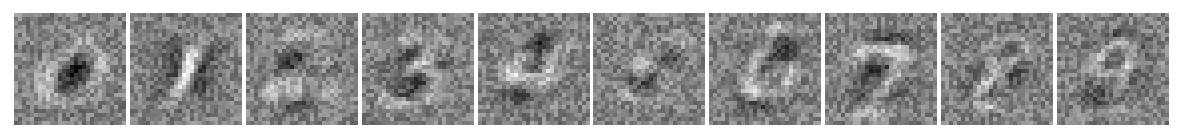

In [22]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

     Incluído no código acima.

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

     Incluído no código acima.

<details>
<summary>Mostrar Resultado</summary>

```python
from IPython import display
import numpy
a = 5
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data)
        weights_d = model.weight.data[4].numpy().reshape(28,28)
        weights_g = model.weight.grad.data[4].numpy().reshape(28,28)
        ww = np.concatenate((weights_d,weights_g),1)
        plt.imshow(ww.reshape((28,28*2)),cmap = 'gray')
        display.display(fig)
        display.clear_output(wait=True)
        input(i)
        
        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()
        print('Accuracy:', accuracy)
        print("epoca: " + str(i + 1))
        print("perda: " + str(loss.data.detach().numpy()))
except KeyboardInterrupt:
    pass
```

</details>



## Perguntas

1. Qual é o shape da matriz de entrada na rede?

Dimensões dos dados das imagens: torch.Size([60000, 28, 28])

ou seja, [60000, 784]

2. Qual é o shape da saída da rede?


[60000, 10]

3. Qual é o número total de parâmetros da rede, incluindo o bias?

In [23]:
784*10+10

7850

# Aprendizados


Para fazer uma predição com a regressão logística não basta passar os dados de entrada pelo modelo treinado, isso produz scores brutos (logits) que precisam passar por uma camada chamada Softmax.

import torch.nn.functional as F

y_pred = model(x_pred)

y_prob = F.softmax(y_pred, dim=1)